In [24]:
!pip install pyspark

In [25]:
from pyspark.sql import SparkSession

In [26]:
spark = SparkSession.builder.appName('Indain_Weather').getOrCreate()

In [27]:
Weather_rdd = spark.sparkContext.textFile("/content/IndianWeatherRepository.csv")

In [28]:
first_row = Weather_rdd.first()
row_elements = first_row.split(",")
for element in row_elements:
    print(element)

country
location_name
region
latitude
longitude
timezone
last_updated_epoch
last_updated
temperature_celsius
temperature_fahrenheit
condition_text
wind_mph
wind_kph
wind_degree
wind_direction
pressure_mb
pressure_in
precip_mm
precip_in
humidity
cloud
feels_like_celsius
feels_like_fahrenheit
visibility_km
visibility_miles
uv_index
gust_mph
gust_kph
air_quality_Carbon_Monoxide
air_quality_Ozone
air_quality_Nitrogen_dioxide
air_quality_Sulphur_dioxide
air_quality_PM2.5
air_quality_PM10
air_quality_us-epa-index
air_quality_gb-defra-index
sunrise
sunset
moonrise
moonset
moon_phase
moon_illumination


In [29]:
null_values = Weather_rdd.filter(lambda line: any(field == "" for field in line.split(",")))

# Count the number of null and missing values
num_null_values = null_values.count()

# Display the number of null and missing values
print("Number of null and missing values:", num_null_values)

Number of null and missing values: 0


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:

Weather_df = spark.read.csv("/content/IndianWeatherRepository.csv", header=True, inferSchema=True)

In [32]:
columns_to_remove = ["country","location_name","region" ,"timezone", "temperature_fahrenheit", "gust_mph", "wind_mph",
                     "wind_direction","last_updated", "last_updated_epoch","condition_text", "wind_mph", "wind_direction",
                     "pressure_mb", "precip_mm", "visibility_miles", "gust_mph","air_quality_PM2.5", "sunrise",
                     "sunset", "moonrise", "moonset", "moon_phase", "moon_illumination"]

Weather_df = Weather_df.drop(*columns_to_remove)

In [33]:
Weather_df.show()

+--------+---------+-------------------+--------+-----------+-----------+---------+--------+-----+------------------+---------------------+-------------+--------+--------+---------------------------+-----------------+----------------------------+---------------------------+----------------+------------------------+--------------------------+
|latitude|longitude|temperature_celsius|wind_kph|wind_degree|pressure_in|precip_in|humidity|cloud|feels_like_celsius|feels_like_fahrenheit|visibility_km|uv_index|gust_kph|air_quality_Carbon_Monoxide|air_quality_Ozone|air_quality_Nitrogen_dioxide|air_quality_Sulphur_dioxide|air_quality_PM10|air_quality_us-epa-index|air_quality_gb-defra-index|
+--------+---------+-------------------+--------+-----------+-----------+---------+--------+-----+------------------+---------------------+-------------+--------+--------+---------------------------+-----------------+----------------------------+---------------------------+----------------+---------------------

In [34]:
Weather_df.dtypes

[('latitude', 'double'),
 ('longitude', 'double'),
 ('temperature_celsius', 'double'),
 ('wind_kph', 'double'),
 ('wind_degree', 'int'),
 ('pressure_in', 'double'),
 ('precip_in', 'double'),
 ('humidity', 'int'),
 ('cloud', 'int'),
 ('feels_like_celsius', 'double'),
 ('feels_like_fahrenheit', 'double'),
 ('visibility_km', 'double'),
 ('uv_index', 'int'),
 ('gust_kph', 'double'),
 ('air_quality_Carbon_Monoxide', 'double'),
 ('air_quality_Ozone', 'double'),
 ('air_quality_Nitrogen_dioxide', 'double'),
 ('air_quality_Sulphur_dioxide', 'double'),
 ('air_quality_PM10', 'double'),
 ('air_quality_us-epa-index', 'int'),
 ('air_quality_gb-defra-index', 'int')]

In [35]:
from pyspark.sql.functions import col

# List of columns to convert to numeric
numeric_columns = ['latitude', 'longitude', 'temperature_celsius', 'wind_kph', 'wind_degree', 'pressure_in',
                   'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit',
                   'visibility_km', 'uv_index', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
                   'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM10',
                   'air_quality_us-epa-index', 'air_quality_gb-defra-index']

# Convert columns to numeric
for column in numeric_columns:
    Weather_df = Weather_df.withColumn(column, col(column).cast('float'))


In [36]:
Weather_df.dtypes

[('latitude', 'float'),
 ('longitude', 'float'),
 ('temperature_celsius', 'float'),
 ('wind_kph', 'float'),
 ('wind_degree', 'float'),
 ('pressure_in', 'float'),
 ('precip_in', 'float'),
 ('humidity', 'float'),
 ('cloud', 'float'),
 ('feels_like_celsius', 'float'),
 ('feels_like_fahrenheit', 'float'),
 ('visibility_km', 'float'),
 ('uv_index', 'float'),
 ('gust_kph', 'float'),
 ('air_quality_Carbon_Monoxide', 'float'),
 ('air_quality_Ozone', 'float'),
 ('air_quality_Nitrogen_dioxide', 'float'),
 ('air_quality_Sulphur_dioxide', 'float'),
 ('air_quality_PM10', 'float'),
 ('air_quality_us-epa-index', 'float'),
 ('air_quality_gb-defra-index', 'float')]

In [37]:
from pyspark import SparkContext
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
# Create a new SparkContext
sc = SparkContext.getOrCreate()

# Create a new SparkSession
spark = SparkSession.builder.getOrCreate()

In [38]:
selected_columns = [
    'temperature_celsius', 'wind_kph', 'wind_degree', 'pressure_in', 'precip_in', 'humidity',
    'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'uv_index', 'gust_kph',
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
    'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index'
]

# Assemble features
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df_assembled = assembler.transform(Weather_df.select(selected_columns)).select("features")


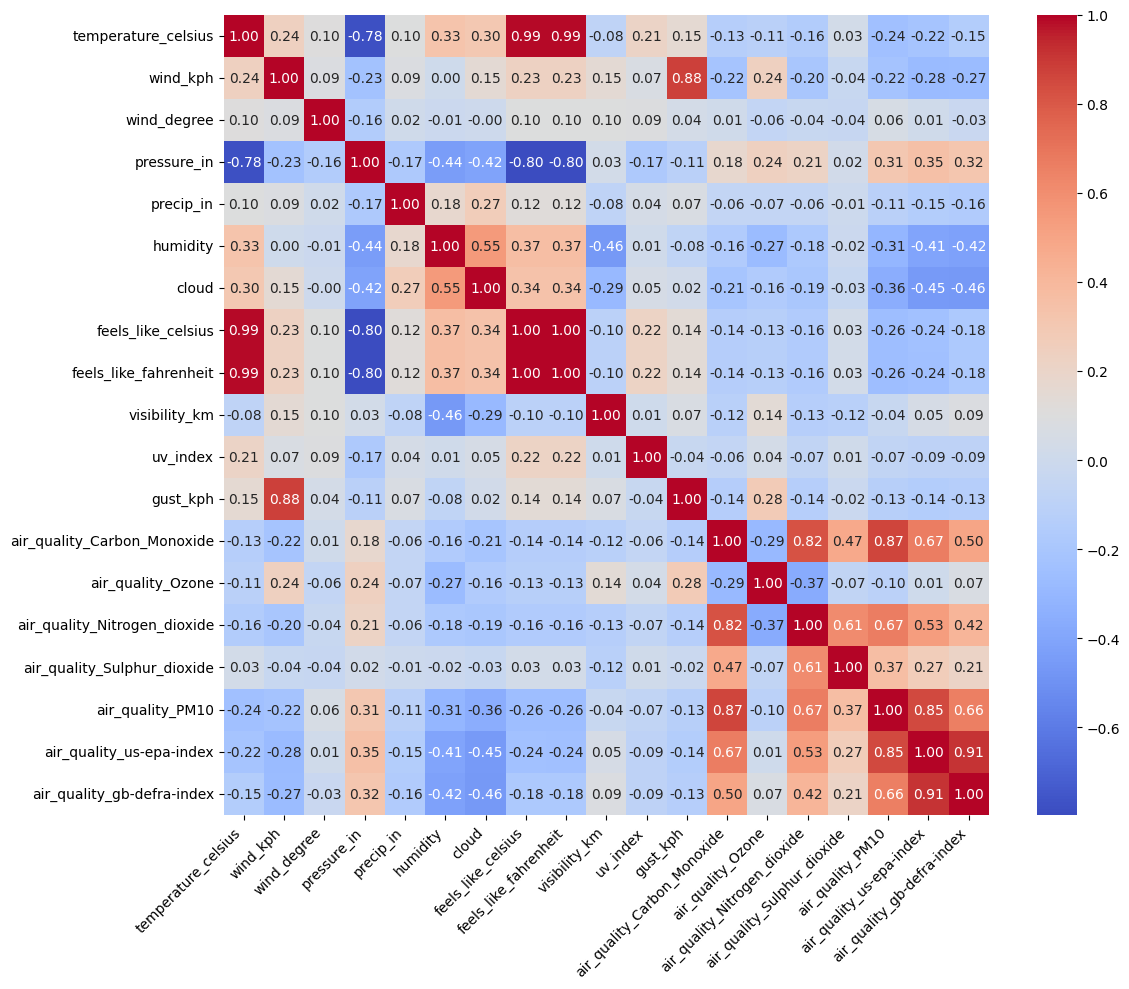

In [39]:
correlation_matrix = Correlation.corr(df_assembled, "features").collect()[0][0]

# Convert correlation matrix to Pandas DataFrame for better visualization
correlation_matrix_df = spark.createDataFrame(correlation_matrix.toArray().tolist(), selected_columns).toPandas()
# Generate heatmap directly from the correlation matrix DataFrame
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix_df, annot=True, cmap='coolwarm', fmt=".2f",
                      xticklabels=correlation_matrix_df.columns, yticklabels=correlation_matrix_df.columns)

# Adjust x-axis label width
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [40]:
# Create temporary view for the DataFrame
Weather_df.createOrReplaceTempView("weather")

# Group by temperature and calculate aggregate statistics for other columns
grouped_df = spark.sql("""
    SELECT temperature_celsius,
           AVG(humidity) AS avg_humidity,
           AVG(wind_kph) AS avg_wind_kph,
           AVG(visibility_km) AS avg_visibility_km,
           AVG(pressure_in) AS avg_pressure_in
    FROM weather
    GROUP BY temperature_celsius
""")

# Show the result
grouped_df.show()


+-------------------+------------------+------------------+------------------+------------------+
|temperature_celsius|      avg_humidity|      avg_wind_kph| avg_visibility_km|   avg_pressure_in|
+-------------------+------------------+------------------+------------------+------------------+
|                9.1|           46.6375| 6.107500004768371|              10.0|30.047250080108643|
|                9.4| 53.66990291262136| 6.288349512711312|  9.45631067961165|30.052330109679584|
|               18.5| 60.96143250688705|6.6019283496972285| 9.399449035812673|29.952809872377674|
|               22.2| 68.44483362521892| 7.896147109998713| 9.411558669001751| 29.85921186991623|
|               18.0| 74.33725029377203| 5.918801369874374|5.3613396004700355|30.006580502950488|
|                6.9| 59.88636363636363|  6.56818180734461| 9.818181818181818| 30.08249993757768|
|               -8.8|              51.5|6.8500001430511475|              10.0|30.302500247955322|
|               -7.9

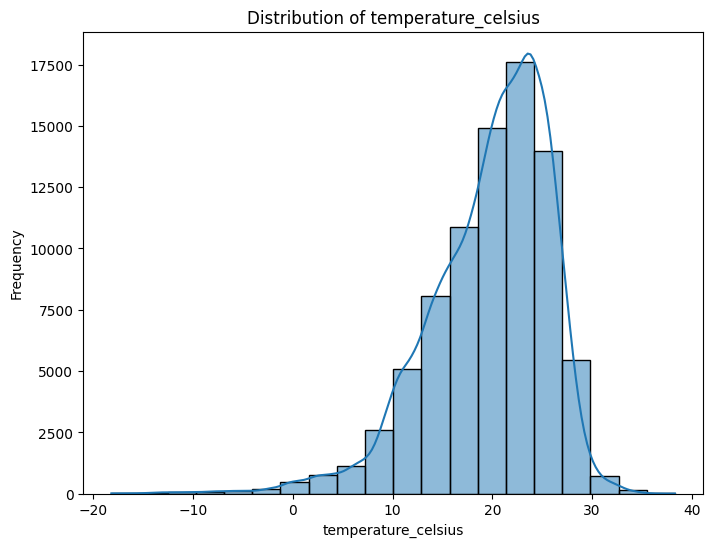

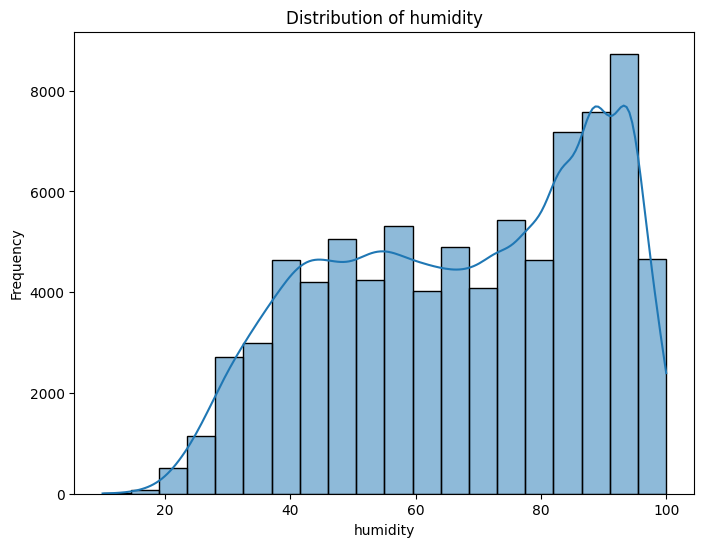

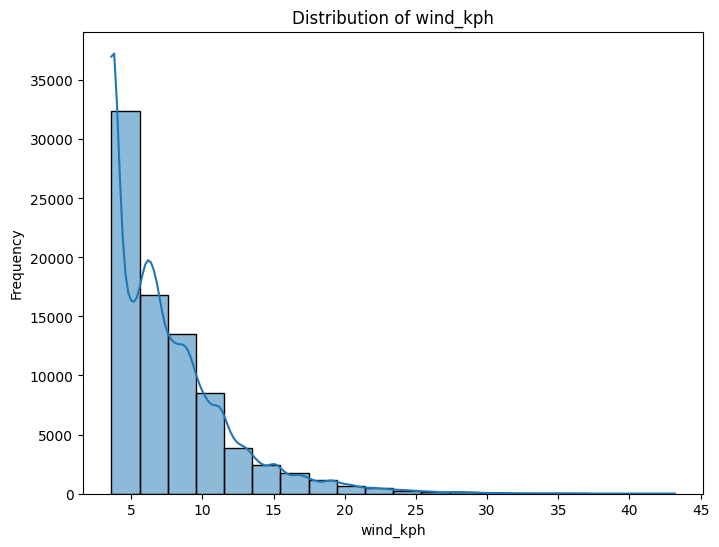

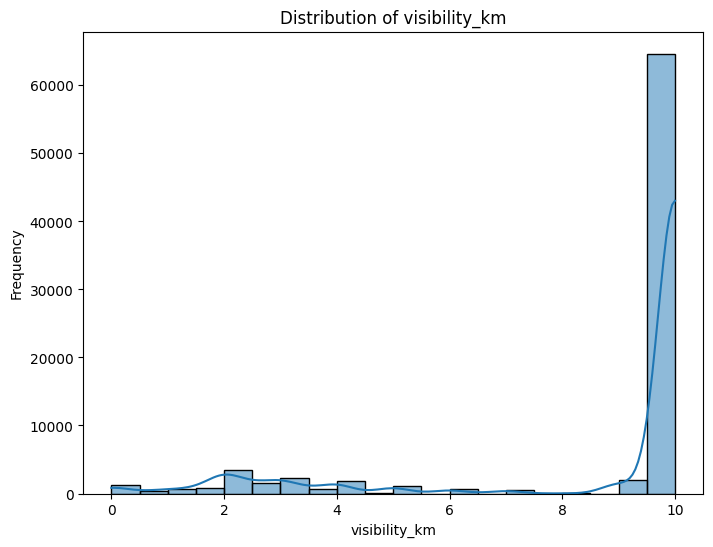

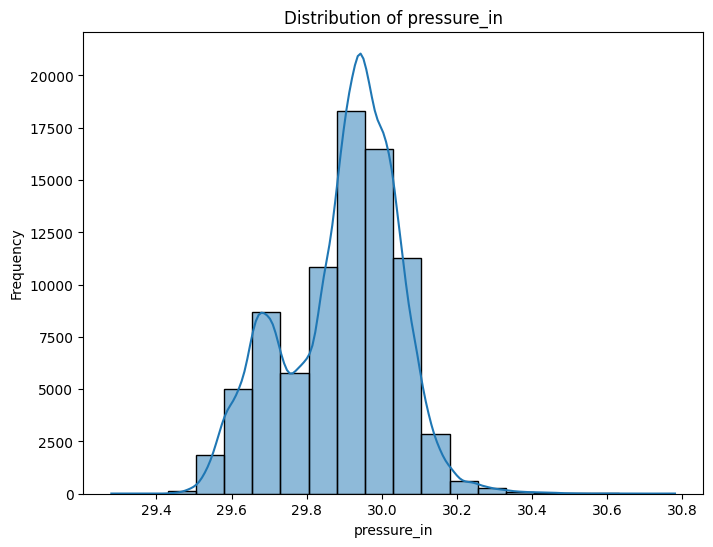

In [41]:
numeric_features = ['temperature_celsius', 'humidity', 'wind_kph', 'visibility_km', 'pressure_in']
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=Weather_df.toPandas(), x=feature, bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


In [42]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.feature import VectorAssembler

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Feature Scaling Example") \
    .getOrCreate()

# Assuming Weather_df is your PySpark DataFrame
# You may need to create a VectorAssembler if your data isn't already in a vector format

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=['humidity', 'wind_kph', 'visibility_km', 'pressure_in'], outputCol="assembled_features")
Weather_df = assembler.transform(Weather_df)

# Standardization (Z-score normalization)
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features_std", withStd=True, withMean=True)
scaler_model_std = scaler.fit(Weather_df)
Weather_df_scaled_std = scaler_model_std.transform(Weather_df)

# Min-Max Scaling (Normalization)
scaler_minmax = MinMaxScaler(inputCol="assembled_features", outputCol="scaled_features_minmax")
scaler_model_minmax = scaler_minmax.fit(Weather_df)
Weather_df_scaled_minmax = scaler_model_minmax.transform(Weather_df)


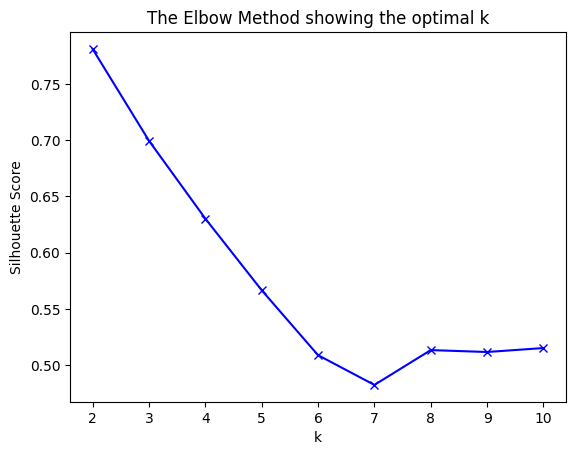

Best k value: 2
Cluster Centers:
[29.96081001 47.04104175  7.39989442  9.83009908]
[29.8405479  84.08996195  7.63667934  7.64355203]
Silhouette Score: 0.7811366711914043


In [43]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Selecting features
selected_features = ['pressure_in', 'humidity', 'wind_kph', 'visibility_km']
assembler = VectorAssembler(inputCols=selected_features, outputCol="features_to_cluster")
output = assembler.transform(Weather_df)

# Initialize K-Means clustering model
k_values = range(2, 11)  # Trying k values from 2 to 10
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(k=k, featuresCol='features_to_cluster', predictionCol='cluster')
    kmeans_model = kmeans.fit(output)
    output_with_clusters = kmeans_model.transform(output)
    evaluator = ClusteringEvaluator(featuresCol='features_to_cluster', predictionCol='cluster', metricName='silhouette')
    silhouette = evaluator.evaluate(output_with_clusters)
    silhouette_scores.append(silhouette)

# Plotting the results
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Find the best k value
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print("Best k value:", best_k)

# Fit K-Means model on data with the best k value
best_kmeans = KMeans(k=best_k, featuresCol='features_to_cluster', predictionCol='cluster')
best_kmeans_model = best_kmeans.fit(output)
output_with_clusters = best_kmeans_model.transform(output)

# Find the centers of the clusters
centers = best_kmeans_model.clusterCenters()
print("Cluster Centers:")
for center in centers:
    print(center)

# Print silhouette score
print("Silhouette Score:", max(silhouette_scores))


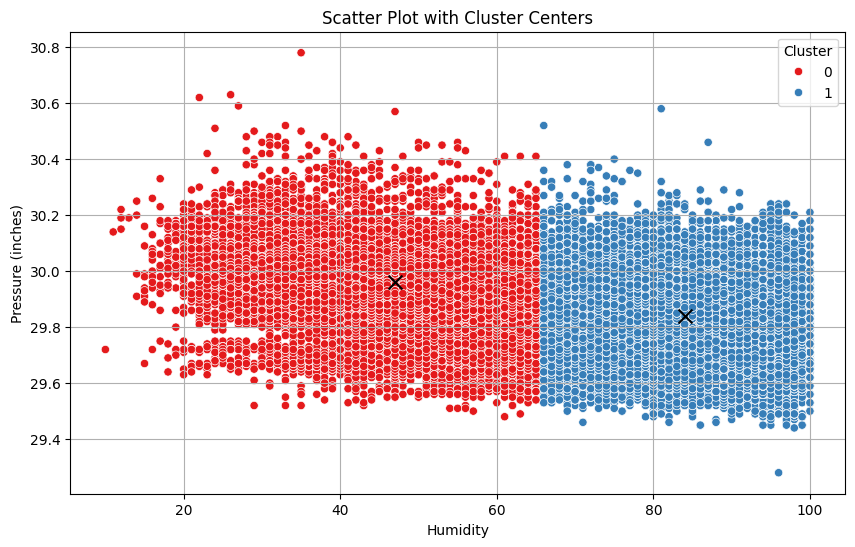

Cluster Center for Cluster 0 : [29.96081001 47.04104175  7.39989442  9.83009908]
Cluster Center for Cluster 1 : [29.8405479  84.08996195  7.63667934  7.64355203]


In [44]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert PySpark DataFrame to Pandas DataFrame
output_pd = output_with_clusters.select(selected_features + ['cluster']).toPandas()

# Plot scatter plot with hue by cluster assignment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=output_pd, x='humidity', y='pressure_in', hue='cluster', palette='Set1')

# Overlay cluster centers on scatter plot for clusters 0 and 1
for center in centers:
    plt.scatter(center[1], center[0], color='black', marker='x', s=100)  # Overlay cluster centers

plt.xlabel('Humidity')
plt.ylabel('Pressure (inches)')
plt.title('Scatter Plot with Cluster Centers')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Display cluster centers separately for cluster 0 and cluster 1
for cluster_id in range(len(centers)):
    cluster_center = centers[cluster_id]
    print("Cluster Center for Cluster", cluster_id, ":", cluster_center)


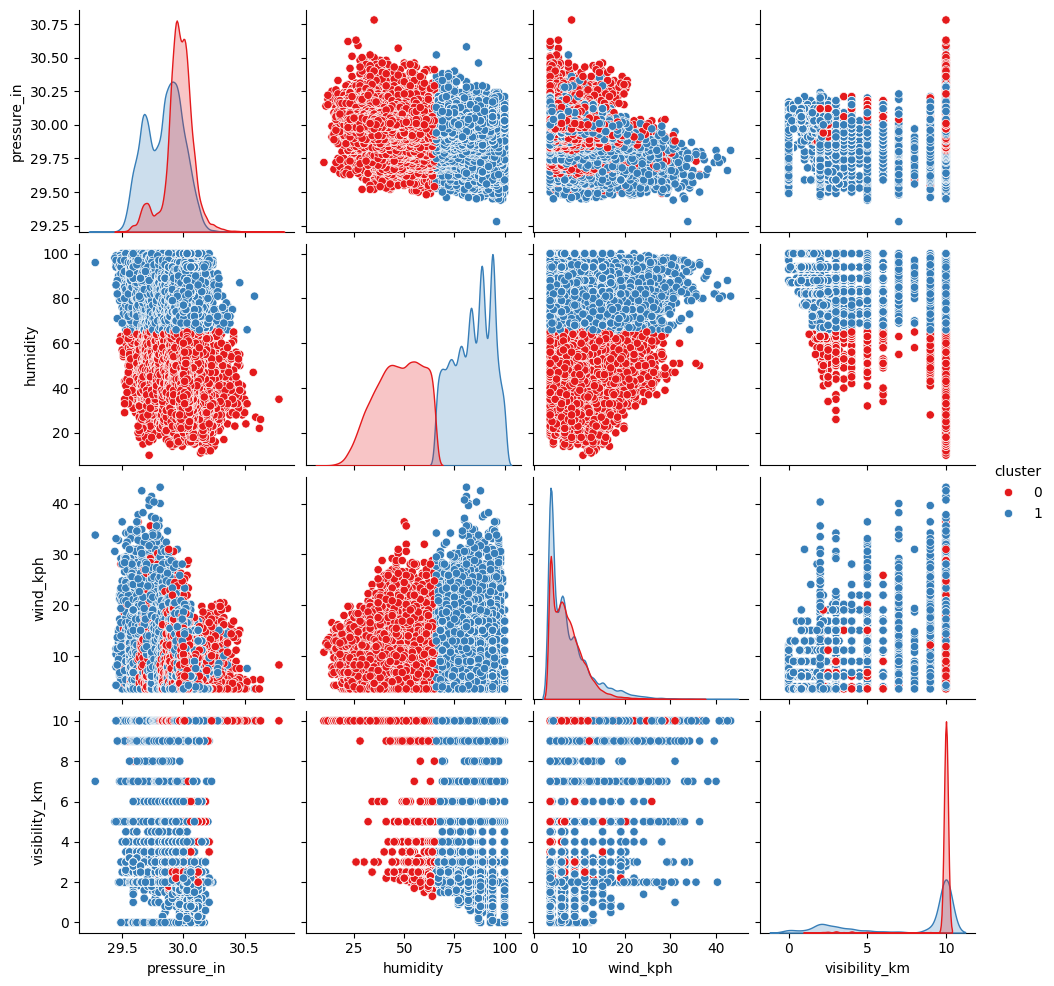

In [45]:
import seaborn as sns
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
output_pd = output_with_clusters.select(selected_features + ['cluster']).toPandas()

# Plot pair plot with hue by cluster assignment
sns.pairplot(output_pd, hue='cluster', palette='Set1')
plt.show()


In [46]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("DecisionTreeRegressionEvaluation") \
    .getOrCreate()

# Assuming 'Weather_df' is your DataFrame containing the weather data

# Define selected features and target variable
selected_features = ['pressure_in', 'humidity', 'wind_kph', 'visibility_km']
target_variable = 'temperature_celsius'

# Create a VectorAssembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
output = assembler.transform(Weather_df)

# Split the data into training and testing sets
train_data, test_data = output.randomSplit([0.8, 0.2], seed=42)

# Initialize Decision Tree Regression model
dt = DecisionTreeRegressor(featuresCol='features', labelCol=target_variable)

# Define parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(labelCol=target_variable, predictionCol="prediction", metricName="r2")

# Initialize cross-validator
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit cross-validator to training data
cv_model = crossval.fit(train_data)

# Make predictions on test data
predictions = cv_model.transform(test_data)

# Evaluate the model
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})

print("R-squared (R²):", r2)
print("Root Mean Squared Error (RMSE):", rmse)

# Best model's parameters
best_model = cv_model.bestModel
print("Best model's parameters:")
print("Max Depth:", best_model.getMaxDepth())
print("Min Instances per Node:", best_model.getMinInstancesPerNode())




R-squared (R²): 0.7582499096055205
Root Mean Squared Error (RMSE): 3.0089655503371673
Best model's parameters:
Max Depth: 7
Min Instances per Node: 5


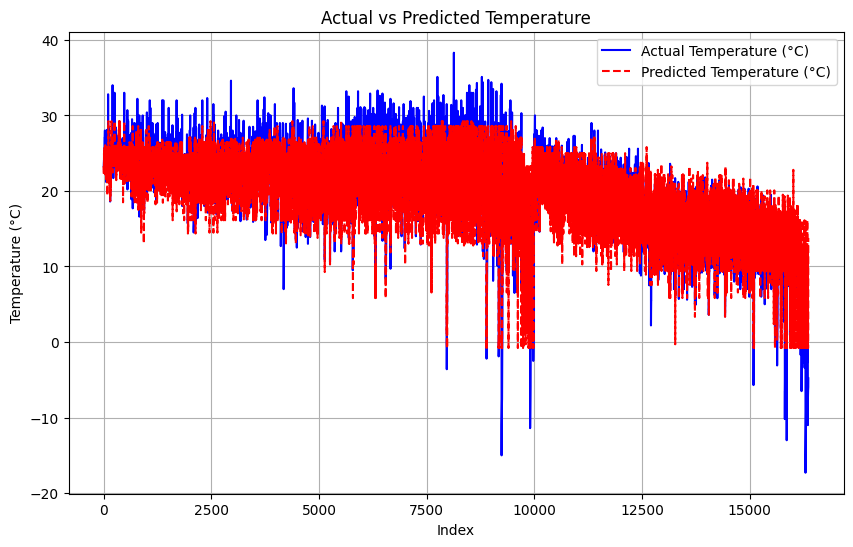

In [47]:
import matplotlib.pyplot as plt

# Plot actual vs predicted temperature using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(predictions.select('temperature_celsius').collect(), color='blue', label='Actual Temperature (°C)')
plt.plot(predictions.select('prediction').collect(), color='red', linestyle='--', label='Predicted Temperature (°C)')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
!wget https://weatherproject.s3.amazonaws.com/weather/IndianWeatherRepository.csv

--2025-08-09 16:02:35--  https://weatherproject.s3.amazonaws.com/weather/IndianWeatherRepository.csv
Resolving weatherproject.s3.amazonaws.com (weatherproject.s3.amazonaws.com)... 52.219.142.76, 3.5.128.203, 52.219.233.156, ...
Connecting to weatherproject.s3.amazonaws.com (weatherproject.s3.amazonaws.com)|52.219.142.76|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-08-09 16:02:35 ERROR 403: Forbidden.



In [49]:
Weather_rdd = spark.sparkContext.textFile("IndianWeatherRepository.csv")

first_row = Weather_rdd.first()
row_elements = first_row.split(",")
for element in row_elements:
    print(element)

country
location_name
region
latitude
longitude
timezone
last_updated_epoch
last_updated
temperature_celsius
temperature_fahrenheit
condition_text
wind_mph
wind_kph
wind_degree
wind_direction
pressure_mb
pressure_in
precip_mm
precip_in
humidity
cloud
feels_like_celsius
feels_like_fahrenheit
visibility_km
visibility_miles
uv_index
gust_mph
gust_kph
air_quality_Carbon_Monoxide
air_quality_Ozone
air_quality_Nitrogen_dioxide
air_quality_Sulphur_dioxide
air_quality_PM2.5
air_quality_PM10
air_quality_us-epa-index
air_quality_gb-defra-index
sunrise
sunset
moonrise
moonset
moon_phase
moon_illumination
